# Neural Network from Scratch in TensorFlow

# Task 1: Introduction and Importing Libraries

In [28]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import nn_utils
%matplotlib inline

print('TensorFlow Version:', tf.__version__)

TensorFlow Version: 2.1.0


# Task 2: Initializing Neural Network

In [29]:
# Densly fully connected NN
class NeuralNetwork:
    def __init__(self, layers):
        # layers = [features, units_in_hidden_Layer, classes]
        self.layers = layers
        self.L = len(layers)
        self.num_features = layers[0]
        self.num_classes = layers[-1]
        
        self.W = {} # Weights dict
        self.b = {} # Biases dict
        
        self.dW = {} # Weight gradient
        self.db = {} # Bias gradient
        
        self.setup()
        
    def setup(self):
        # Your code here
        for i in range(1, self.L):
            # i=0 is no of features, hence we start from i=1
            self.W[i] = tf.Variable(tf.random.normal(shape=(self.layers[i],self.layers[i-1])))
            # Shape = no. of nodes in curr layer by precedding layer
            # can also use random.uniform instead of random.normal
            self.b[i] = tf.Variable(tf.random.normal(shape=(self.layers[i],1)))

# Task 3: Forward Pass

In [30]:
# Extending the previous class
class NeuralNetwork(NeuralNetwork):
    def forward_pass(self, X):
        # Your code here
        # X=input to our function
        A = tf.convert_to_tensor(X, dtype=tf.float32)
        for i in range(1, self.L):
            Z = tf.matmul(A, tf.transpose(self.W[i]))+tf.transpose(self.b[i])
            # Z = W.X+b
            if i!=self.L-1: # if layer is not final layer
                A = tf.nn.relu(Z)
                # Activation function.
            else:
                A=Z
        return A

# Task 4: Computing Loss and Updating Parameters

In [31]:
# Extending the previous class
class NeuralNetwork(NeuralNetwork):
    # Your code here
    def compute_loss(self, A, Y):
        loss = tf.nn.softmax_cross_entropy_with_logits(Y, A)
        return tf.reduce_mean(loss)
    
    def update_params(self,lr):
        for i in range(1,self.L):
            self.W[i].assign_sub(lr*self.dW[i])
            # Subtract value as: W = W-lr*dW
            self.b[i].assign_sub(lr*self.db[i])

# Task 5: Predict and Info Functions

In [32]:
class NeuralNetwork(NeuralNetwork):
    def predict(self, X):
        # Your code here
        A = self.forward_pass(X)
        return tf.argmax(tf.nn.softmax(A),axis=1)
        # softmax to predict the output
        # argmax to predict the output class
    
    def info(self):
        num_params = 0
        for i in range(1, self.L):
            num_params += self.W[i].shape[0] * self.W[i].shape[1]
            num_params += self.b[i].shape[0]
        print('Input Features:', self.num_features)
        print('Number of Classes:', self.num_classes)
        print('Hidden Layers:')
        print('--------------')
        for i in range(1, self.L-1):
            print('Layer {}, Units {}'.format(i, self.layers[i]))
        print('--------------')
        print('Number of parameters:', num_params)

# Task 6: Training on Batch

In [33]:
class NeuralNetwork(NeuralNetwork):
    def train_on_batch(self, X, Y, lr):
        # Your code here
        X = tf.convert_to_tensor(X, dtype=tf.float32)
        Y = tf.convert_to_tensor(Y, dtype=tf.float32)
        
        # To run backward propagation.....
        with tf.GradientTape(persistent=True) as tape:
            A = self.forward_pass(X)
            loss = self.compute_loss(A,Y)
            
        # Calc gradient for all the layers
        for i in range(1, self.L):
            self.dW[i] = tape.gradient(loss, self.W[i])
            self.db[i] = tape.gradient(loss, self.b[i])
        del tape
        self.update_params(lr)
        return loss.numpy()

# Task 7: Training on Complete Set

In [34]:
class NeuralNetwork(NeuralNetwork):
    def train(self, x_train, y_train, x_test, y_test, epochs, steps_per_epoch, batch_size, lr):
        # Your code here
        history ={
            'val_loss' : [],
            'train_loss' : [],
            'val_acc' : [],
        }
        
        # instead of running all the iter for all eg, we're running for a mini-batch
        # if batch_size=100 and 1000 egs, the steps_per_epoch=10
        for e in range(0, epochs):
            epoch_train_loss = 0
            print('Epoch {}'.format(e+1),end='#')
            for i in range(0, steps_per_epoch):
                x_batch = x_train[i*batch_size:(i+1)*batch_size]
                y_batch = y_train[i*batch_size:(i+1)*batch_size]
                
                batch_loss = self.train_on_batch(x_batch, y_batch, lr)
                epoch_train_loss += batch_loss
                
                # Fashion piece of code:
                if i%int(steps_per_epoch/10) ==0:
                    print(end="#")
                
            # Store history for every epoch
            history['train_loss'].append(epoch_train_loss/steps_per_epoch)
            # get output from a validation set...val_A
            val_A = self.forward_pass(x_test)
            val_LOss = self.compute_loss(val_A,y_test).numpy()
            history['val_loss'].append(val_LOss)
            val_preds = self.predict(x_test)
            # y_test is multi-categorical/one-hot encoded vec. So we need to calc max numerical value
            # and check how many are correct => gives us total number.
            # Hence we calc mean of those vals.
            val_acc = np.mean(np.argmax(y_test, axis=1)==val_preds.numpy())
            history['val_acc'].append(val_acc)
            print('  Val_accuracy: ',val_acc)
        return history

# Task 8: Application

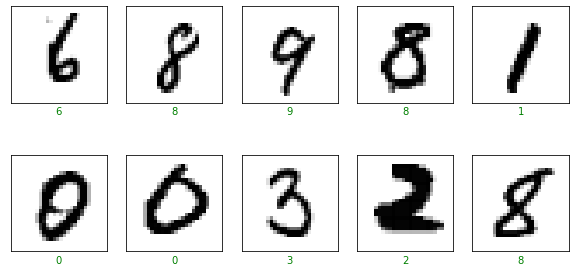

In [35]:
(x_train, y_train), (x_test, y_test) = nn_utils.load_data()
nn_utils.plot_random_examples(x_train, y_train).show()

In [36]:
# MNIST has 784 features (28,28)
# 2 hidden layers with 128 units each
# 10 classes
net = NeuralNetwork([784, 128, 128, 10])
net.info()

Input Features: 784
Number of Classes: 10
Hidden Layers:
--------------
Layer 1, Units 128
Layer 2, Units 128
--------------
Number of parameters: 118282


In [37]:
# 60k eg in train-set
batch_size = 120
epochs = 25
steps_per_epoch = int(x_train.shape[0]/batch_size)
lr = 3e-3
print('Steps per epoch: ',steps_per_epoch)

Steps per epoch:  500


In [38]:
history = net.train(x_train, y_train, x_test, y_test, epochs, steps_per_epoch, batch_size,lr)

Epoch 1###########  Val_accuracy:  0.8272
Epoch 2###########  Val_accuracy:  0.8545
Epoch 3###########  Val_accuracy:  0.8664
Epoch 4###########  Val_accuracy:  0.8753
Epoch 5###########  Val_accuracy:  0.8782
Epoch 6###########  Val_accuracy:  0.8849
Epoch 7###########  Val_accuracy:  0.8864
Epoch 8###########  Val_accuracy:  0.8889
Epoch 9###########  Val_accuracy:  0.891
Epoch 10###########  Val_accuracy:  0.8922
Epoch 11###########  Val_accuracy:  0.8933
Epoch 12###########  Val_accuracy:  0.8937
Epoch 13###########  Val_accuracy:  0.8954
Epoch 14###########  Val_accuracy:  0.8967
Epoch 15###########  Val_accuracy:  0.8969
Epoch 16###########  Val_accuracy:  0.8987
Epoch 17###########  Val_accuracy:  0.899
Epoch 18###########  Val_accuracy:  0.9004
Epoch 19###########  Val_accuracy:  0.9017
Epoch 20###########  Val_accuracy:  0.9019
Epoch 21###########  Val_accuracy:  0.9036
Epoch 22###########  Val_accuracy:  0.9034
Epoch 23###########  Val_accuracy:  0.9041
Epoch 24###########  V

# Task 9: Results

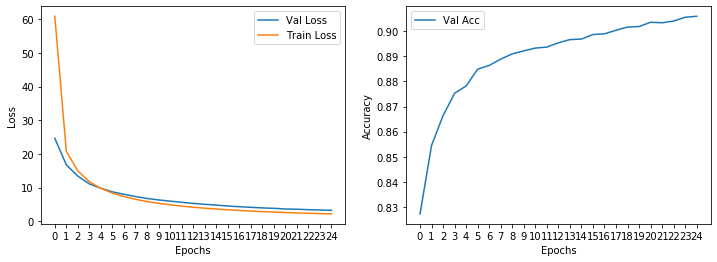

In [39]:
nn_utils.plot_results(history).show()

In [40]:
preds = net.predict(x_test)

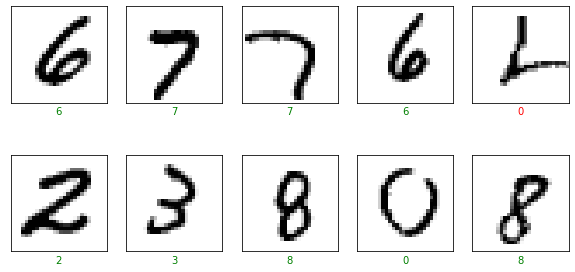

In [41]:
nn_utils.plot_random_examples(x_test, y_test, preds.numpy()).show()